In [1]:
import numpy as np
import sys
import requests
import urllib
from datetime import datetime, timedelta
import numpy
from lxml import etree
from osgeo import gdal
#import eventlet
#from eventlet.green import urllib2
import urllib3
import numpy.ma as ma

In [2]:
def datelist_regular_coverage(root, start_date, start, cur_date):
    """
    retrieve regular datelist and requested current position in regards to total no. of observations
    """

    #print start
    tmp_date=datetime(start.year,cur_date.month,cur_date.day)
    if tmp_date > start :
        start=(tmp_date-datetime(1601,1,1)).days
    else: start=(datetime(start.year+1,cur_date.month,cur_date.day)-datetime(1601,1,1)).days
    datelist=range(start+1,end_date-1,365)
    print datelist

    #find the position of the requested date in the datelist
    cur_epoch=(cur_date-datetime(1601,1,1)).days
    cur_pos=min(range(len(datelist)),key=lambda x:abs(datelist[x]-cur_epoch))
    print ('Current position:',cur_pos)    
    
    return datelist, cur_pos

In [3]:
def datelist_irregular_coverage(root, start_date, start, cur_date):
    """
    retrieve irregular datelist and requested current position in regards to total no. of observations
    """
    
    #root[0]                - wcs:CoverageDescription
    #root[0][0]             - boundedBy 
    #root[0][0][0]          - Envelope
    #root[0][0][0][0]       - lowerCorner
    # --- 
    #root[0]                - wcs:CoverageDescription
    #root[0][3]             - domainSet
    #root[0][3][0]          - gmlrgrid:ReferenceableGridByVectors
    #root[0][3][0][5]       - gmlrgrid:generalGridAxis
    #root[0][3][0][5][0]    - gmlrgrid:GeneralGridAxis
    #root[0][3][0][5][0][1] - gmlrgrid:coefficients

    # get sample size coefficients from XML root
    sample_size = root[0][3][0][5][0][1].text #sample size
    #print root[0][3][0][5][0][1].text #sample size
    
    # use coverage start_date and sample_size array to create all dates in ANSI
    array_stepsize = np.fromstring(sample_size, dtype=int, sep=' ')
    #print np.fromstring(sample_size, dtype=int, sep=' ')
    array_all_ansi = array_stepsize + start_date   
    
    # create array of all dates in ISO
    list_all_dates = []
    for stepsize in array_stepsize:
        date_and_stepsize = start + timedelta(stepsize - 1)
        list_all_dates.append(date_and_stepsize)
        #print date_and_stepsize
    array_all_dates = np.array(list_all_dates)  
    
    # create array of all dates as DOY
    list_all_yday = []
    for j in array_all_dates:
        yday = j.timetuple().tm_yday
        list_all_yday.append(yday)
        #print yday
    array_all_yday = np.array(list_all_yday)    
    
    # subtract user date of all dates in ISO 
    # to find the nearest available coverage date
    array_diff_dates = array_all_dates - cur_date
    idx_nearest_date = find_nearest(array_diff_dates, timedelta(0))
    nearest_date = array_all_dates[idx_nearest_date]    
    
    # select all coresponding DOY of all years for ANSI and ISO dates
    array_selected_ansi = array_all_ansi[array_all_yday == nearest_date.timetuple().tm_yday]
    array_selected_dates = array_all_dates[array_all_yday == nearest_date.timetuple().tm_yday]
    print array_selected_ansi
    
    # get index of nearest date in selection array
    idx_nearest_date_selected = numpy.where(array_selected_dates==nearest_date)[0][0]  
    print idx_nearest_date_selected
    
    # return datelist in ANSI and the index of the nearest date
    return array_selected_ansi, idx_nearest_date_selected

In [4]:
def find_nearest(array,value):
    return (np.abs(array-value)).argmin()

In [5]:
def chunkify(lst,n):
     return [ lst[i::n] for i in xrange(n) ]

In [6]:
date = '2014-06-25'
##request image cube for the specified date and area by WCS.
#firstly we get the temporal length of avaliable NDVI data from the DescribeCoverage of WCS
endpoint='http://192.168.1.104:8080/rasdaman/ows'
field={}
field['SERVICE']='WCS'
field['VERSION']='2.0.1'
field['REQUEST']='DescribeCoverage'
field['COVERAGEID']='NDVI_MOD13C1005_uptodate'#'NDVI_MOD13C1005'#'trmm_3b42_coverage_1'
url_values = urllib.urlencode(field,doseq=True)
full_url = endpoint + '?' + url_values
data = urllib.urlopen(full_url).read()
root = etree.fromstring(data)
lc = root.find(".//{http://www.opengis.net/gml/3.2}lowerCorner").text
uc = root.find(".//{http://www.opengis.net/gml/3.2}upperCorner").text
start_date=int((lc.split(' '))[2])
end_date=int((uc.split(' '))[2])
#print [start_date, end_date]

#generate the dates list 
cur_date=datetime.strptime(date,"%Y-%m-%d")
#startt=145775
start=datetime.fromtimestamp((start_date-(datetime(1970,01,01)-datetime(1601,01,01)).days)*24*60*60)

In [7]:
try:    
    datelist, cur_pos = datelist_irregular_coverage(root, start_date, start, cur_date)
    print 'irregular'
except IndexError:
    datelist, cur_pos = datelist_regular_coverage(root, start_date, start, cur_date)
    print 'regular'

[145908 146274 146639 147004 147369 147735 148100 148465 148830 149196
 149561 149926 150291 150657 151022 151387]
14
irregular


In [8]:
spl_arr = [-179,-60,179,90]

In [8]:
import requests

In [20]:
cube_arr=[]
urls = []
for d in datelist:
    print 'NDVI: ', d        
    field={}
    field['SERVICE']='WCS'
    field['VERSION']='2.0.1'
    field['REQUEST']='GetCoverage'
    field['COVERAGEID']='NDVI_MOD13C1005_uptodate'#'NDVI_MOD13C1005'#'trmm_3b42_coverage_1'
    field['SUBSET']=['ansi('+str(d)+')',
                     'Lat('+str(spl_arr[1])+','+str(spl_arr[3])+')',
                    'Long('+str(spl_arr[0])+','+str(spl_arr[2])+')']
    field['FORMAT']='image/tiff'
    url_values = urllib.urlencode(field,doseq=True)
    full_url = endpoint + '?' + url_values
    urls.append(full_url)
    #print full_url
ixs = range(len(urls))    

NDVI:  145908
NDVI:  146274
NDVI:  146639
NDVI:  147004
NDVI:  147369
NDVI:  147735
NDVI:  148100
NDVI:  148465
NDVI:  148830
NDVI:  149196
NDVI:  149561
NDVI:  149926
NDVI:  150291
NDVI:  150657
NDVI:  151022
NDVI:  151387


In [94]:
#blockSizes = utils.GetBlockSize(band)
xBlockSize = 50
yBlockSize = 50
# get image size
rows = 90 # -60 :: 90
cols = 179 # -179 :: 179
#rows = -59
#cols = -178

In [140]:
#http = urllib3.PoolManager(10)
conn = urllib3.connection_from_url(endpoint,maxsize=4)
cube_arr=[]
# loop through the rows
for d in datelist[0:1]:

    for i in range(-60, rows, yBlockSize): #(rowx-1, rowx, yBlockSize)
        if i + yBlockSize < rows:
            numRows = yBlockSize
        else:
            numRows = rows - i

        # loop through the columns
        for j in range(-179, cols, xBlockSize): #(coly-1, coly, xBlockSize)
            if j + xBlockSize < cols:
                numCols = xBlockSize
            else:
                numCols = cols - j

            print (j, i, j+numCols, i+numRows)
            spl_arr = [j, i, j+numCols, i+numRows]
            # set base array to fill 
            #ap_trmm = np.zeros(shape=(len(files_trmm),numRows,numCols), dtype=np.float32)
            #ap_ndvi = np.zeros(shape=(len(files_ndvi),numRows,numCols), dtype=np.float32)

            # select blocks from trmm and ndvi files
            #for m in range(len(files_trmm)):

            urls = []
            print 'NDVI: ', d        
            field={}
            field['SERVICE']='WCS'
            field['VERSION']='2.0.1'
            field['REQUEST']='GetCoverage'
            field['COVERAGEID']='NDVI_MOD13C1005_uptodate'#'NDVI_MOD13C1005'#'trmm_3b42_coverage_1'
            field['SUBSET']=['ansi('+str(d)+')',
                             'Lat('+str(spl_arr[1])+','+str(spl_arr[3])+')',
                            'Long('+str(spl_arr[0])+','+str(spl_arr[2])+')']
            field['FORMAT']='image/tiff'
            url_values = urllib.urlencode(field,doseq=True)
            full_url = endpoint + '?' + url_values
            #full_url = '?' + url_values
            print full_url
            urls.append(full_url)
                #print full_url
            ixs = range(len(urls)) 
            
            # create temp filenames based on date and area
            spl_arr = str(spl_arr).replace('[','')
            spl_arr = str(spl_arr).replace(']','')
            spl_arr = str(spl_arr).replace(' ','')
            spl_arr = str(spl_arr).replace(',','')
            tmp_name = '/vsimem/'+str(d)+'_'+spl_arr
            print tmp_name

            #for url in urls:
    #             r = http.request('GET', url)
            r = conn.request('GET', full_url)
            gdal.FileFromMemBuffer(tmp_name, r.data)
            #ds = gdal.Open('/vsimem/tiffinmem')
            cube_arr.append(tmp_name)



(-179, -60, -129, -10)
NDVI:  145908
http://192.168.1.104:8080/rasdaman/ows?SUBSET=ansi%28145908%29&SUBSET=Lat%28-60%2C-10%29&SUBSET=Long%28-179%2C-129%29&SERVICE=WCS&FORMAT=image%2Ftiff&REQUEST=GetCoverage&VERSION=2.0.1&COVERAGEID=NDVI_MOD13C1005_uptodate
/vsimem/145908_-179-60-129-10
(-129, -60, -79, -10)
NDVI:  145908
http://192.168.1.104:8080/rasdaman/ows?SUBSET=ansi%28145908%29&SUBSET=Lat%28-60%2C-10%29&SUBSET=Long%28-129%2C-79%29&SERVICE=WCS&FORMAT=image%2Ftiff&REQUEST=GetCoverage&VERSION=2.0.1&COVERAGEID=NDVI_MOD13C1005_uptodate
/vsimem/145908_-129-60-79-10
(-79, -60, -29, -10)
NDVI:  145908
http://192.168.1.104:8080/rasdaman/ows?SUBSET=ansi%28145908%29&SUBSET=Lat%28-60%2C-10%29&SUBSET=Long%28-79%2C-29%29&SERVICE=WCS&FORMAT=image%2Ftiff&REQUEST=GetCoverage&VERSION=2.0.1&COVERAGEID=NDVI_MOD13C1005_uptodate
/vsimem/145908_-79-60-29-10
(-29, -60, 21, -10)
NDVI:  145908
http://192.168.1.104:8080/rasdaman/ows?SUBSET=ansi%28145908%29&SUBSET=Lat%28-60%2C-10%29&SUBSET=Long%28-29%2C21%29

array([[-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000

In [117]:
import subprocess as sp

In [148]:
gdal_merge = r'C:\Program Files\GDAL//gdal_merge.py'
temp_out = 'out.tif'
command = [gdal_merge, '-of','GTiff','-o', temp_out] + cube_arr
print (sp.list2cmdline(command))

norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)  
norm.communicate()   

"C:\Program Files (x86)\GDAL//gdal_merge.py" -of GTiff -o out.tif /vsimem/145908_-179-60-129-10 /vsimem/145908_-129-60-79-10 /vsimem/145908_-79-60-29-10 /vsimem/145908_-29-6021-10 /vsimem/145908_21-6071-10 /vsimem/145908_71-60121-10 /vsimem/145908_121-60171-10 /vsimem/145908_171-60179-10 /vsimem/145908_-179-10-12940 /vsimem/145908_-129-10-7940 /vsimem/145908_-79-10-2940 /vsimem/145908_-29-102140 /vsimem/145908_21-107140 /vsimem/145908_71-1012140 /vsimem/145908_121-1017140 /vsimem/145908_171-1017940 /vsimem/145908_-17940-12990 /vsimem/145908_-12940-7990 /vsimem/145908_-7940-2990 /vsimem/145908_-29402190 /vsimem/145908_21407190 /vsimem/145908_714012190 /vsimem/145908_1214017190 /vsimem/145908_1714017990


('', None)

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

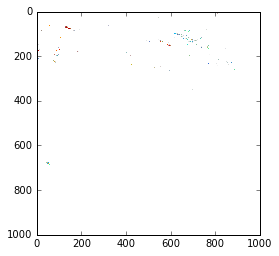

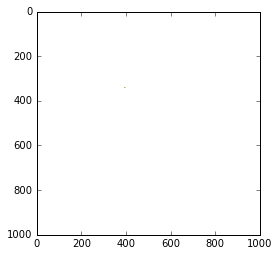

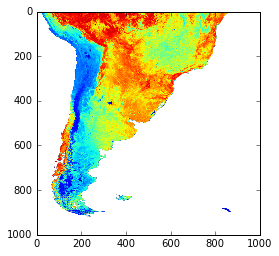

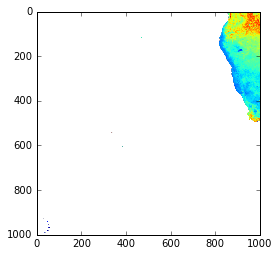

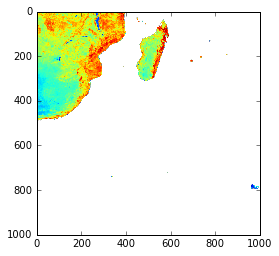

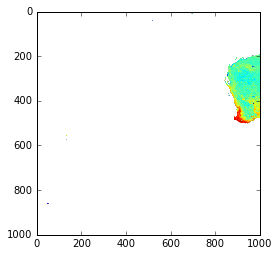

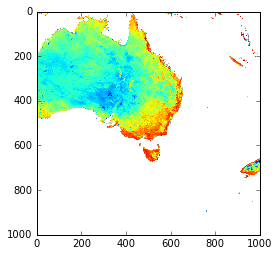

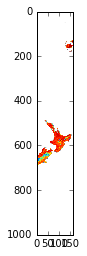

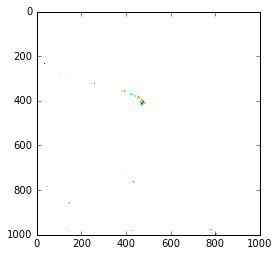

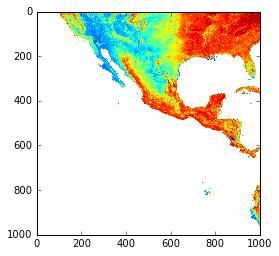

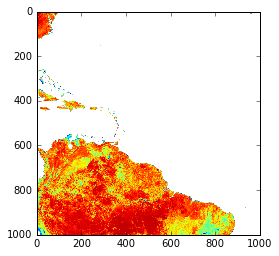

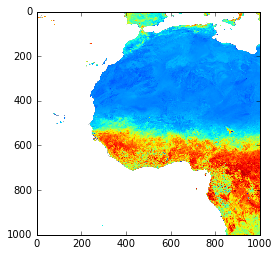

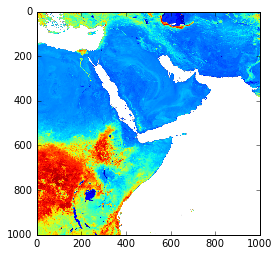

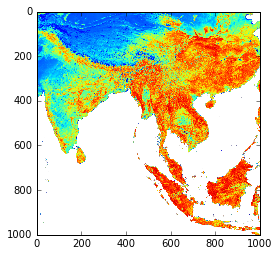

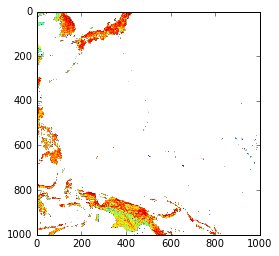

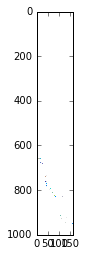

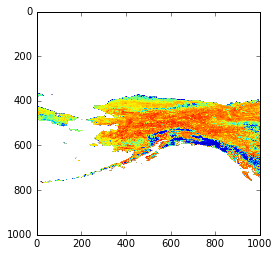

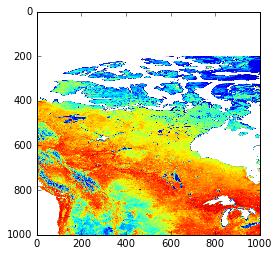

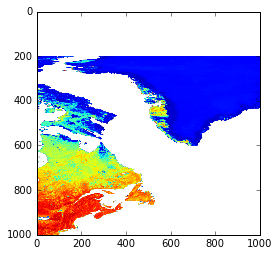

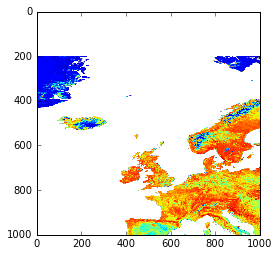

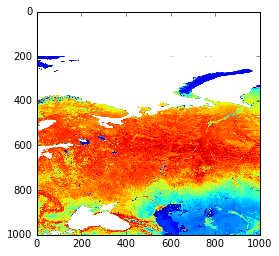

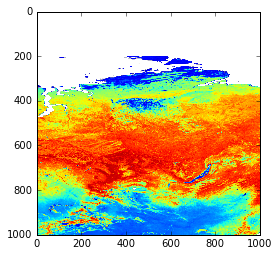

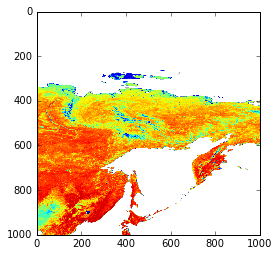

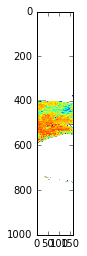

In [146]:
for chunk in cube_arr:
    #print chunk
    ds = gdal.Open(chunk)
    #print ds
    chunk_ma = ma.masked_equal(numpy.asarray(ds.ReadAsArray()),-3000)
    #print chunk_ma
    plt.imshow(chunk_ma)
    plt.show()

In [123]:
#sys.path.insert(0, r'C:\Program Files\GDAL')


In [125]:
#command = [gdal_merge, "-cutline", CHN_adm_gpkg, "-csql", 
#           "SELECT NAME_3 FROM CHN_adm3 WHERE NAME_1 = '"+NAME_1+"' and NAME_2 = '"+NAME_2+"' and NAME_3 = '"+NAME_3+"'", 
#           "-crop_to_cutline", "-of", "GTiff", "-dstnodata", "-9999", tmpfilename, clippedfilename, "-overwrite"]

#logging.info(sp.list2cmdline(command))


"C:\Program Files\GDAL//gdal_merge.py" -of GTiff -o /vsimem/temp /vsimem/145908_-179-60-129-10 /vsimem/145908_-129-60-79-10 /vsimem/145908_-79-60-29-10 /vsimem/145908_-29-6021-10 /vsimem/145908_21-6071-10 /vsimem/145908_71-60121-10 /vsimem/145908_121-60171-10 /vsimem/145908_171-60179-10 /vsimem/145908_-179-10-12940 /vsimem/145908_-129-10-7940 /vsimem/145908_-79-10-2940 /vsimem/145908_-29-102140 /vsimem/145908_21-107140 /vsimem/145908_71-1012140 /vsimem/145908_121-1017140 /vsimem/145908_171-1017940 /vsimem/145908_-17940-12990 /vsimem/145908_-12940-7990 /vsimem/145908_-7940-2990 /vsimem/145908_-29402190 /vsimem/145908_21407190 /vsimem/145908_714012190 /vsimem/145908_1214017190 /vsimem/145908_1714017990


In [102]:
% gdal_merge.py -init 255 -o out.tif in1.tif in2.tif

array([[-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000],
       [-3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000,
        -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000, -3000

In [70]:
cube_arr_ma=ma.masked_equal(numpy.asarray(cube_arr),-3000)

In [73]:
cube_arr_ma.shape

(1L, 21L, 21L)

In [46]:
from urllib3 import HTTPConnectionPool

In [88]:
spl_arr = str(spl_arr).replace('[','')
spl_arr = str(spl_arr).replace(']','')
spl_arr = str(spl_arr).replace(' ','')
spl_arr = str(spl_arr).replace(',','')
tmp_name = str(d)+'_'+spl_arr

In [89]:
tmp_name

'145908_-179-60-178-59'

In [55]:
conn.timeout()

In [ ]:
http = urllib3.PoolManager(10)


In [28]:
gdal.FileFromMemBuffer('/vsimem/tiffinmem', r.data)
ds = gdal.Open('/vsimem/tiffinmem')

In [ ]:
def fetch(url, ix):
    print "opening url: ", ix
    
    response = urllib2.urlopen(url)
    # Create in-memory file and initialize it with the content
    gdal.FileFromMemBuffer('/vsimem/tiffinmem', response.read())
    # Open the in-memory file
    ds = gdal.Open('/vsimem/tiffinmem')
    assert ds    
    cube_arr.append(ds.ReadAsArray())
    out = url     
    print "done with url: ", ix
    return ix

# create pool of threads
pool = eventlet.GreenPool(200)

for urls_chunk in chunkify(urls,5):
    # start farming jobs
    for ix in pool.imap(fetch, urls_chunk, datelist):
        print "finished url", ix 

In [ ]:
# def fetch(url, ix):
#     print "opening url: ", ix
    
#     response = urllib2.urlopen(url)
#     # Create in-memory file and initialize it with the content
#     gdal.FileFromMemBuffer('/vsimem/tiffinmem', response.read())
#     # Open the in-memory file
#     ds = gdal.Open('/vsimem/tiffinmem')
#     assert ds    
#     cube_arr.append(ds.ReadAsArray())
#     out = url     
#     print "done with url: ", ix
#     return ix

# # create pool of threads
# pool = eventlet.GreenPool(200)

# # start farming jobs
# for ix in pool.imap(fetch, urls, ixs):
#     print "finished url", ix